# Unet-Pytorch
Este proyecto nace con la idea de tener una alternativa a la implementación de U-Net en Tensorflow. La idea es que sea lo más parecida posible a la implementación de Tensorflow, pero en Pytorch.

## Importar librerías

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os, random, torch, shutil, cv2
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import random_split, DataLoader, Dataset
import glob

import PIL, skimage.io
from PIL import Image

from lxml import etree


## Comprobar si hay GPU

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Directorios

In [48]:
# Localización de los frames
annotation_file = "data/annotations.xml"
frames_dir = "data/frames/"
train_location = "data/train/"
mask_location = "data/mask/"
frames = os.listdir(frames_dir)

print(len(frames))
labels = {"acera":0,
          "ciclovia":0,
          "cruceZebra":0}


2892


In [35]:
frames[:5]

['calzada_galvan_0.jpg',
 'calzada_galvan_1.jpg',
 'calzada_galvan_10.jpg',
 'calzada_galvan_100.jpg',
 'calzada_galvan_1000.jpg']

## Creación del dataset

In [49]:
class Unet_Dataset(Dataset):
  def __init__(self, data, masks=None, img_transform=None, mask_transform=None):
    '''
    data - train data path
    masks - train masks path
    '''
    self.train_data = data
    self.train_masks = masks
    
    self.img_transform = img_transform
    self.mask_transform = mask_transform
    
    self.images = sorted(os.listdir(self.train_data))
    self.masks = sorted(os.listdir(self.train_masks))
    
  def __len__(self):
    if self.train_masks is not None:
      assert len(self.images) == len(self.masks), "Images and masks must have the same length"
    return len(self.images)
  
  def __getitem__(self, idx):
    image_name = os.path.join(self.train_data, self.images[idx])
    img = Image.open(image_name)
    trans = T.ToTensor()
    if self.img_transform is not None:
      
      img = self.img_transform(img)
    else:
      # En caso de no tener transformaciones, se convierte a tensor de PyTorch
      img = trans(img)
    
    if self.train_masks is not None:
      mask_name = os.path.join(self.train_masks, self.masks[idx])
      mask = Image.open(mask_name)
      
      if self.mask_transform is not None:
        mask = self.mask_transform(mask)
      else:
        # En caso de no tener transformaciones, se convierte a tensor de PyTorch
        mask = trans(mask)
      
      # Normalizamos la mascara, sabiendo que solo hay 3 clases
      mask_max = mask.max().item()
      mask /= mask_max
      
    else:
      return img
    
    return img, mask

## Transformaciones

In [50]:
# Definimos las transformaciones para las imagenes y las mascaras
# Por ahora solo redimensionamos a 224x224, pero se pueden agregar mas
# transformaciones como rotaciones, recortes, etc.
transform_data = T.Compose([
  T.Resize((224, 224)),
  T.ToTensor()])

## Dataloader

In [55]:
full_dataset = Unet_Dataset(
  data=train_location, 
  masks=mask_location, 
  img_transform=transform_data,
  mask_transform=transform_data)

BATCH_SIZE = 32
TRAIN_SIZE = int(0.8 * len(full_dataset))
VAL_SIZE = len(full_dataset) - TRAIN_SIZE  # Datos de validación

print("Datos de entrenamiento: ", TRAIN_SIZE)
print("Datos de validación: ", VAL_SIZE)

Datos de entrenamiento:  2182
Datos de validación:  546


In [56]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
len(train_dataset), len(val_dataset)

(2182, 546)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [60]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])


In [59]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==9: break

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
4 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
5 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
6 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
7 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
8 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])
9 torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])


## Visualización de imágenes

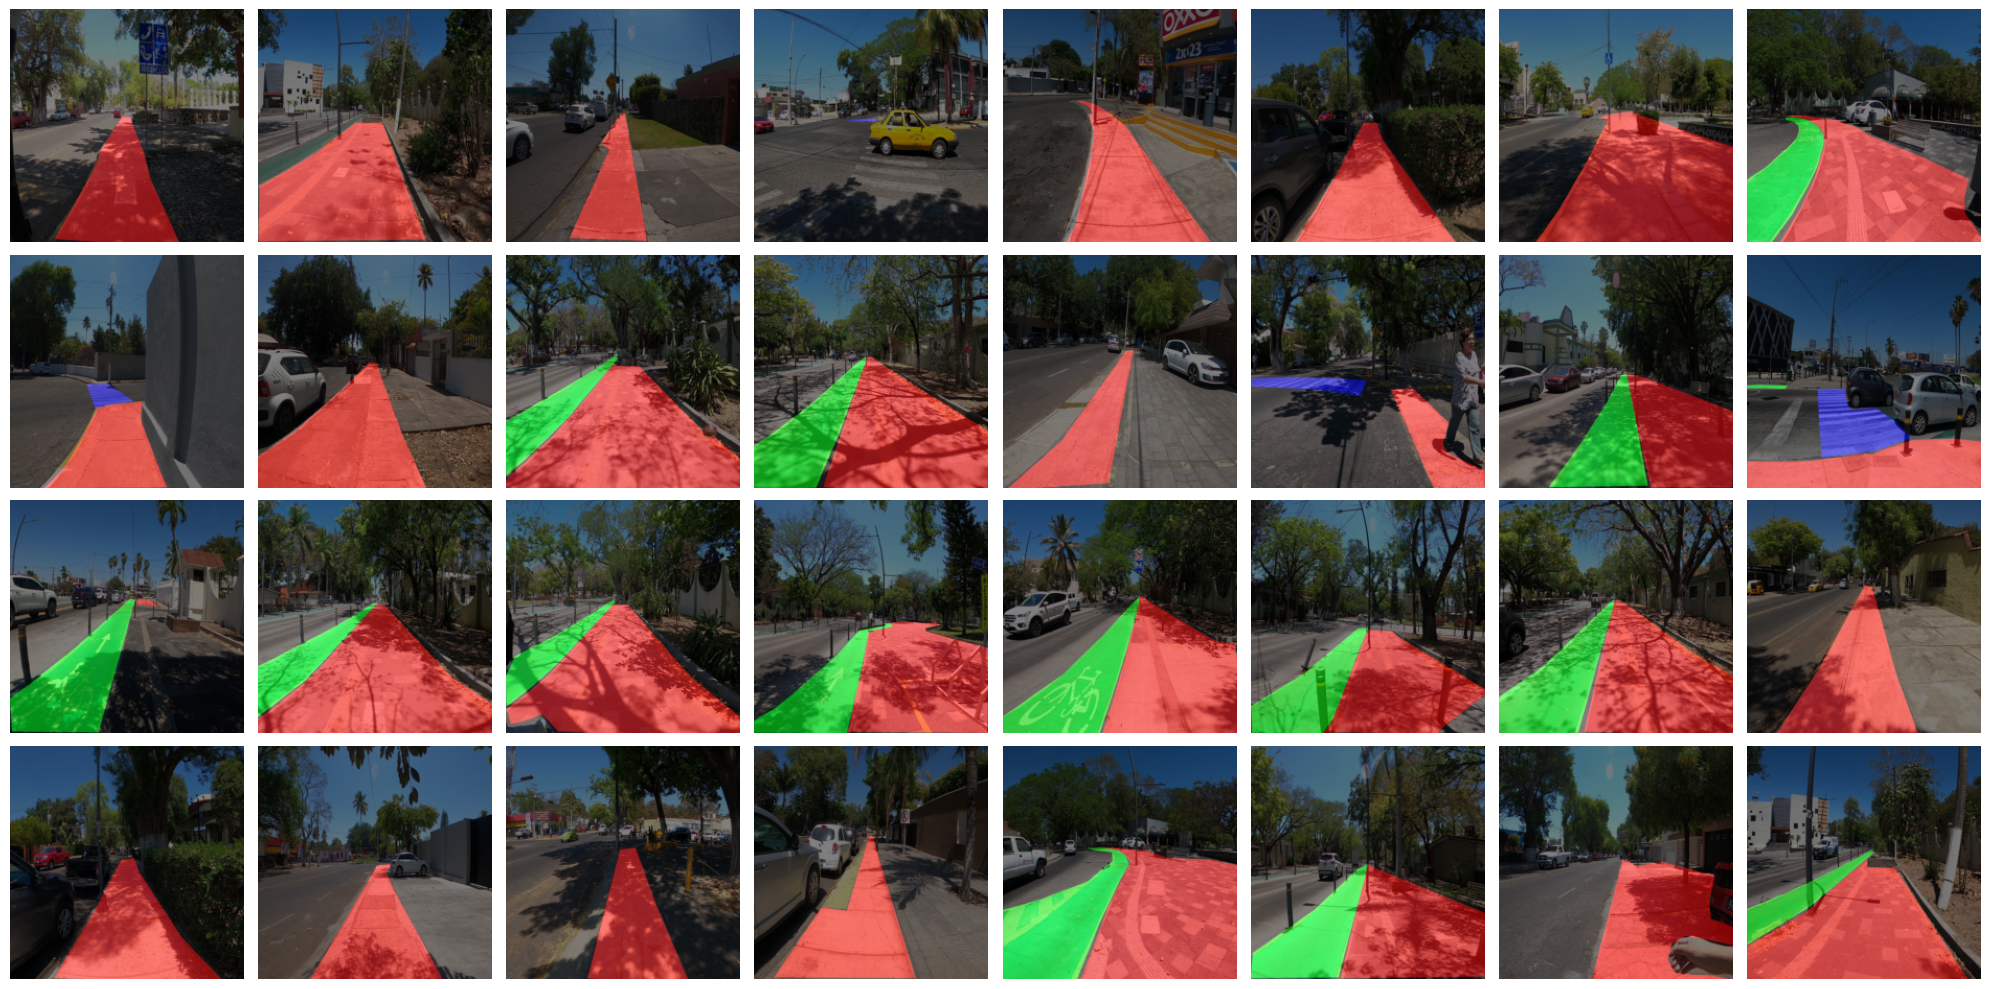

In [61]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)